In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorboard.plugins import projector

c:\Users\prave\Sentiment_Analysis\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
BATCH_SIZE = 64

In [3]:
train_ds, val_ds, test_ds = tfds.load('imdb_reviews', split = ['train', 'test[:50%]', 'test[50%:]'],as_supervised = True)

In [4]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
for review, label in val_ds.take(2):
    print(review)
    print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [6]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_tag = tf.strings.regex_replace(lowercase, "<[^>]+>","")
    output = tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [7]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [8]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [9]:
vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = SEQUENCE_LENGTH
)

In [10]:
training_data = train_ds.map(lambda x,y:x)
vectorize_layer.adapt(training_data)

In [11]:
len(vectorize_layer.get_vocabulary())

10000

In [12]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [13]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [14]:
vectorize_layer.get_vocabulary()[411]

np.str_('absolutely')

In [15]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [16]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
inputs = np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn = tf.keras.layers.SimpleRNN(25)
output = simple_rnn(inputs)
print(output.shape)

(32, 25)


In [18]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
os.makedirs("sentiment_analysis/checkpoints", exist_ok=True)
os.makedirs("sentiment_analysis/final_model", exist_ok=True)

checkpoint_filepath = "sentiment_analysis/checkpoints/best_model.keras"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False)

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,)
    #callbacks=[model_checkpoint_callback])

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step - accuracy: 0.5048 - loss: 0.6938 - val_accuracy: 0.5218 - val_loss: 0.6918
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.6259 - loss: 0.6599 - val_accuracy: 0.6481 - val_loss: 0.6483
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.6355 - loss: 0.6507 - val_accuracy: 0.5178 - val_loss: 0.6913
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.5871 - loss: 0.6678 - val_accuracy: 0.5339 - val_loss: 0.6881
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.7118 - loss: 0.5851 - val_accuracy: 0.7656 - val_loss: 0.5322
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8273 - loss: 0.4456 - val_accuracy: 0.8056 - val_loss: 0.4668
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.8614 - loss: 0.3722 - val_accuracy: 0.7591 - val_loss: 0.4906
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.8864 - loss: 0.3277 - 

In [22]:
model.save("sentiment_analysis/final_model/trained_model.keras")

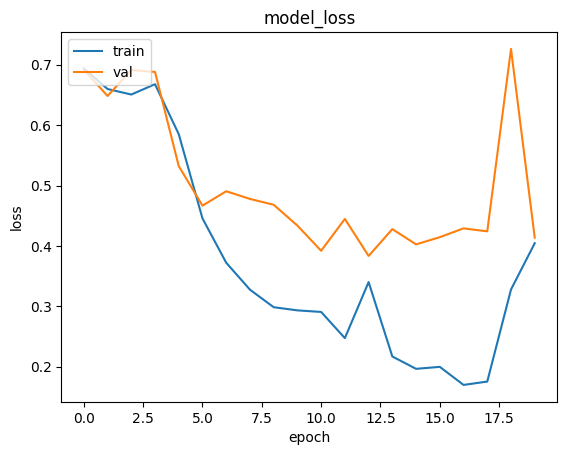

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

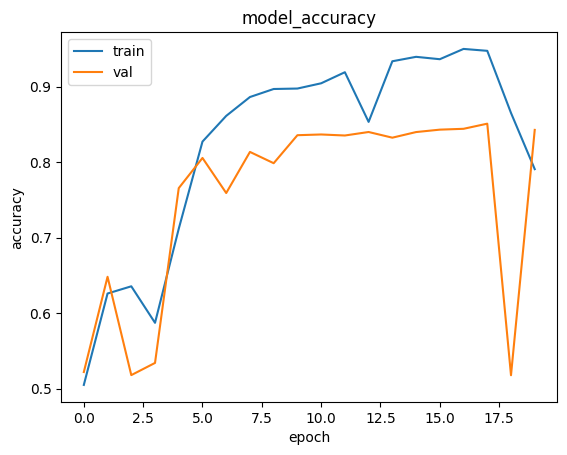

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9609 - loss: 0.1511


[0.1510620415210724, 0.9608799815177917]

In [26]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 250, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
checkpoint_filepath = "sentiment_analysis/checkpoints/LSTM.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 160s 390ms/step - accuracy: 0.6556 - loss: 0.5925 - val_accuracy: 0.8293 - val_loss: 0.3939
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 306ms/step - accuracy: 0.8742 - loss: 0.3191 - val_accuracy: 0.8446 - val_loss: 0.3768
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 126s 321ms/step - accuracy: 0.9120 - loss: 0.2422 - val_accuracy: 0.8559 - val_loss: 0.3745
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 127s 324ms/step - accuracy: 0.9332 - loss: 0.2018 - val_accuracy: 0.8614 - val_loss: 0.3880
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 122s 312ms/step - accuracy: 0.9436 - loss: 0.1740 - val_accuracy: 0.8413 - val_loss: 0.4550
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 307ms/step - accuracy: 0.9377 - loss: 0.1762 - val_accuracy: 0.8530 - val_loss: 0.4428
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 119s 304ms/step - accuracy: 0.9462 - loss: 0.1573 - val_accuracy: 0.8465 - val_loss: 0.4817
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 125s 320ms/step - accuracy: 0.9536 -

In [30]:
model.save("sentiment_analysis/final_model/trained_model_LSTM.keras")

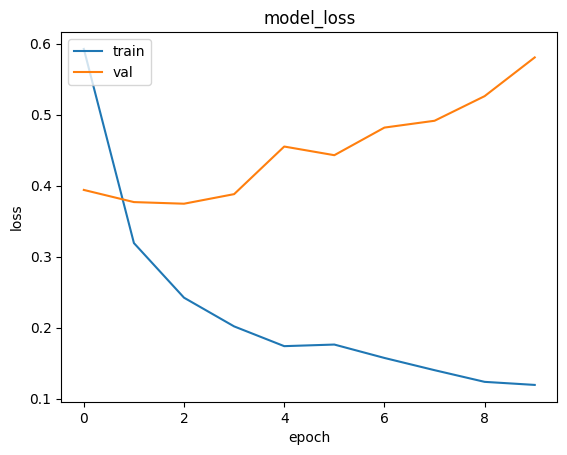

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

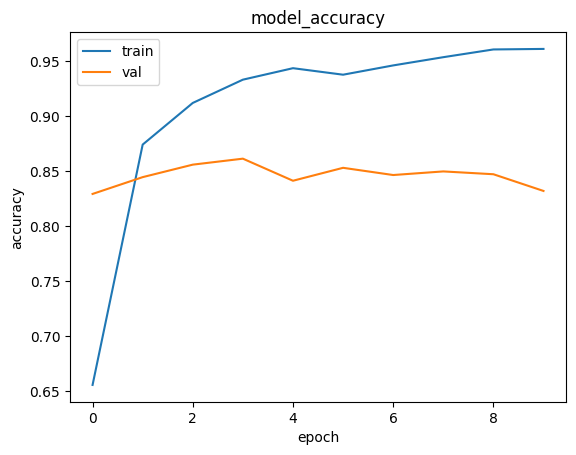

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.8420 - loss: 0.5611


[0.5610798001289368, 0.8420000076293945]

In [34]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 250, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 725,249 (2.77 MB)

 Trainable params: 725,249 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
checkpoint_filepath = "sentiment_analysis/checkpoints/GRU.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [37]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10


 42/391 ━━━━━━━━━━━━━━━━━━━━ 1:54 328ms/step - accuracy: 0.5075 - loss: 0.6935

KeyboardInterrupt: 

In [ ]:
model.save("sentiment_analysis/final_model/trained_model_GRU.keras")

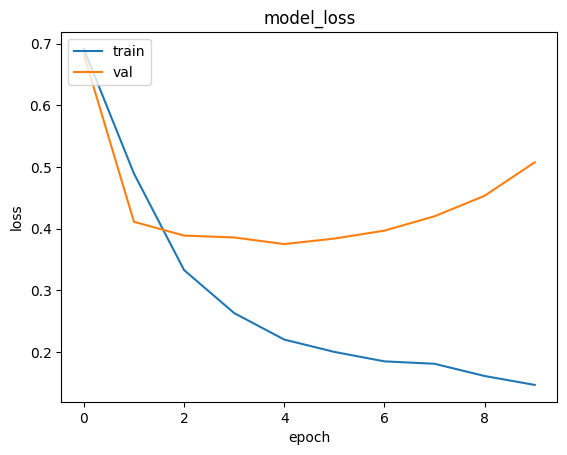

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

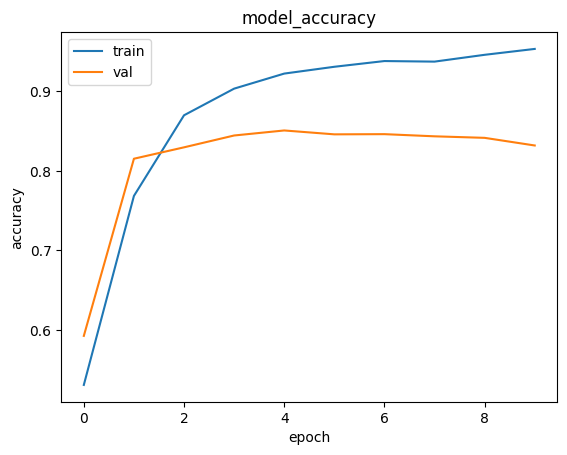

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.8304 - loss: 0.5096


[0.5096120238304138, 0.8303999900817871]

In [18]:
word2vec = api.load('word2vec-google-news-300')

In [19]:
word2vec.vectors.shape

(3000000, 300)

In [21]:
len(word2vec['The'])

300

In [22]:
word2vec.most_similar('Man')

[('Woman', 0.6939345002174377),
 ('Boy', 0.5896925330162048),
 ('Girl', 0.584598958492279),
 ('Suspect', 0.5577560067176819),
 ('Couple', 0.5528685450553894),
 ('man', 0.5316051840782166),
 ('Robber', 0.5315312743186951),
 ('Teenager', 0.5161930322647095),
 ('depicts_Michelangelo_Creation', 0.5148172378540039),
 ('Policeman', 0.5136396884918213)]

In [23]:
pretrained_embeddings=[]

In [24]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [25]:
vectorize_layer.get_vocabulary()[2]

np.str_('the')

In [26]:
first_caps(vectorize_layer.get_vocabulary()[2])

'The'

In [27]:
pretrained_embeddings=[]

In [28]:
len(vectorize_layer.get_vocabulary())

10000

In [29]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))
  if i%1000==0:
    print('iis====================================',i)


nosolution
iis==================================== 0
[UNK]
nosolution
and
toupper
a
toupper
of
toupper
to
toupper
doesnt
nosolution
didnt
nosolution
isnt
nosolution
wasnt
nosolution
10
nosolution
80s
nosolution
20
nosolution
70s
nosolution
iis==================================== 1000
15
nosolution
12
nosolution
30
nosolution
humour
toupper
100
nosolution
hasnt
nosolution
90
nosolution
shouldnt
nosolution
favourite
toupper
theatre
toupper
60s
nosolution
40
nosolution
lowbudget
nosolution
tarzan
toupper
50
nosolution
90s
nosolution
1950s
nosolution
iis==================================== 2000
keaton
toupper
welles
toupper
50s
nosolution
1010
nosolution
11
nosolution
1970s
nosolution
overthetop
nosolution
sinatra
toupper
columbo
toupper
1980s
nosolution
25
nosolution
1930s
nosolution
14
nosolution
13
nosolution
bmovie
nosolution
aint
toupper
pacino
toupper
moviethe
nosolution
writerdirector
nosolution
itthe
nosolution
lugosi
toupper
hitchcock
toupper
810
nosolution
iis===================

In [30]:
pretrained_embeddings_array=np.array(pretrained_embeddings)
print(pretrained_embeddings_array.shape)

(10000, 300)


In [31]:
np.save('sentiment_analysis/pretrained_embeddings',pretrained_embeddings_array)

In [32]:
pretrained_embeddings_array.shape

(10000, 300)

In [36]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 250, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 248, 32)        │        28,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       253,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
checkpoint_filepath = 'sentiment_analysis/conv_1d_word2vec.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [39]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5066 - loss: 0.7106

391/391 ━━━━━━━━━━━━━━━━━━━━ 65s 155ms/step - accuracy: 0.5068 - loss: 0.6972 - val_accuracy: 0.5082 - val_loss: 0.6926
Epoch 2/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5183 - loss: 0.6915

391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5215 - loss: 0.6914 - val_accuracy: 0.5449 - val_loss: 0.6895
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5736 - loss: 0.6702

391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.6351 - loss: 0.6257 - val_accuracy: 0.8062 - val_loss: 0.4599
Epoch 4/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8205 - loss: 0.4241

391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.8356 - loss: 0.3911 - val_accuracy: 0.8517 - val_loss: 0.3478
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8762 - loss: 0.3129

391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.8805 - loss: 0.3020 - val_accuracy: 0.8582 - val_loss: 0.3247
Epoch 6/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9034 - loss: 0.2613

391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.9049 - loss: 0.2547 - val_accuracy: 0.8690 - val_loss: 0.3139
Epoch 7/10
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9203 - loss: 0.2264

391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.9216 - loss: 0.2205 - val_accuracy: 0.8692 - val_loss: 0.3128
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9358 - loss: 0.1893 - val_accuracy: 0.8685 - val_loss: 0.3174
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9447 - loss: 0.1641 - val_accuracy: 0.8665 - val_loss: 0.3323
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9547 - loss: 0.1407 - val_accuracy: 0.8628 - val_loss: 0.3434


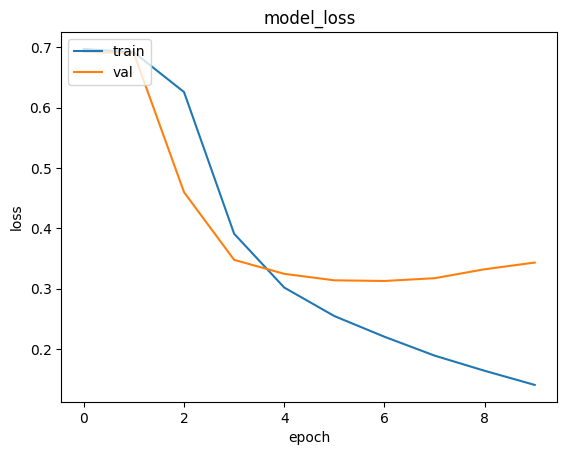

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

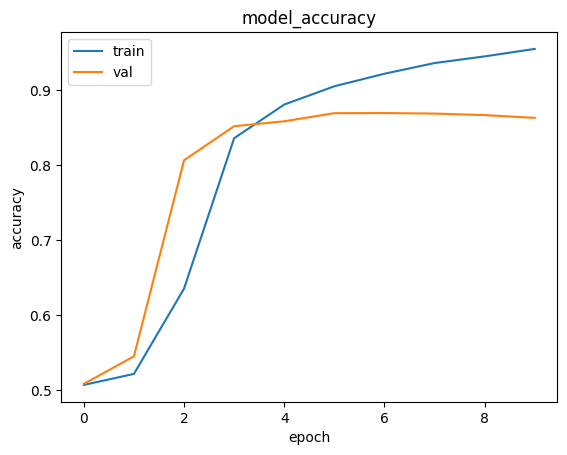

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
model.load_weights(checkpoint_filepath)

In [43]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8618 - loss: 0.3191


[0.3191381096839905, 0.861840009689331]

In [44]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "],])


In [45]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [46]:
model.predict(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


array([[0.5972213 ],
       [0.62073416]], dtype=float32)

In [47]:
inputs = Input(shape=(1,), dtype="string")
vectorized_inputs=vectorize_layer(inputs)
outputs = model(vectorized_inputs)
inference_ready_model = tf.keras.Model(inputs, outputs)
inference_ready_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │     3,282,849 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 250, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 248, 32)        │        28,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       253,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [52]:
log_dir='logs/imdb/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

In [53]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1)

In [54]:
history=model.fit(
    train_dataset.take(34),
    validation_data=val_dataset,
    epochs=1,
    callbacks=[tensorboard_callback])

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.5000 - loss: 0.6936 - val_accuracy: 0.5098 - val_loss: 0.6930


In [55]:
with open(os.path.join(log_dir,'metadata.tsv'),"w",encoding="utf-8") as f:
  for i in range(VOCAB_SIZE):
    f.write("{} {}\n".format(i,vectorize_layer.get_vocabulary()[i]))

In [56]:
embedding_weights=tf.Variable(model.layers[0].get_weights()[0])
print(embedding_weights.shape)

(10000, 300)


In [57]:
%load_ext tensorboard

In [58]:
%tensorboard --logdir logs/imdb/fit/